
# petitRADTRANS Retrieval Tutorial




Written by [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals) and 
Paul Mollière

[Based on Mollière (2020)](https://arxiv.org/abs/2006.09394)

**What is a retrieval?**

Let's start with the basics! 
If you're here, we're going to assume that you already have an exoplanet emission or transmission spectrum, and you want to learn something about the planet's properties. 
We'll use the petitRADTRANS (pRT) package, a 1D atmospheric radiative transfer tool, combined with a sampler which will allow us to statistically measure the properties of the planet of interest. 
As inputs for this, you'll need a 1D spectrum with error bars (or a covariance matrix), and a model function that generates a synthetic spectrum. We have a few example datasets included in `petitRADTRANS/retrieval/examples/`, and several models included in `petitRADTRANS/retrieval/models.py`, which you can use as templates to build your own model.
For this please check the source on [pRT's gitlab page](https://gitlab.com/mauricemolli/petitRADTRANS/-/tree/master/petitRADTRANS/retrieval/examples). The outputs of this will be a best-fit spectrum, an atmospheric pressure-temperature profile, and the posterior distributions of all of the parameters of your model atmosphere.
Of course, you do not have to use pRT's retrieval package to run retrievals with pRT-generated spectra, but we believe that what is described below may be sufficient for most people, and will thus save you from most of the tedious implementation work.

## Getting started


You should already have an installation of pRT on your machine, please see the [installation manual](../installation.html) if you have not installed it yet. 
[pyMultiNest](https://github.com/JohannesBuchner/PyMultiNest) is also required. [Ultranest](https://johannesbuchner.github.io/UltraNest/index.html) is required if you want to use that as your sampler rather than pyMultiNest. See the Ultranest documentation for why you might want to choose this method.
Using nested sampling rather than MCMC is faster, handles multimodal cases better, and directly provides the Bayesian evidence, which allows for easier model comparison. 


In this tutorial, we will outline the process of setting up a RetrievalConfig object, which is the class used to set up a pRT retrieval.
The basic process will always be to set up the configuration, and then pass it to the Retrieval class to run the retrieval using pyMultiNest.
Several standard plotting outputs will also be produced by the retrieval class.
Most of the classes and functions used in this tutorial have more advanced features than what will be explained here, so it's highly recommended to take a look at the code and API documentation. 
There should be enough flexibility built in to cover most typical retrieval studies, but if you have feature requests please get in touch, or open an issue on [gitlab](https://gitlab.com/mauricemolli/petitRADTRANS.git).



In [1]:
# Let's start by importing everything we need.
import os
# To not have numpy start parallelizing on its own
os.environ["OMP_NUM_THREADS"] = "1"
#os.environ["pRT_input_data_path"] = "/u/nnas/packages/petitRADTRANS/petitRADTRANS/input_data/"

import numpy as np
import matplotlib.pyplot as plt

from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc

# Import the class used to set up the retrieval.
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
# Import Prior functions, if necessary.
from petitRADTRANS.retrieval.util import gaussian_prior
# Import atmospheric model function
# You could also write your own!
from petitRADTRANS.retrieval.models import emission_model_diseq

Let's start with a simple model. 
We'll use an isothermal temperature profile, and use free chemistry - allowing the chemical abundances to vary freely within fixed boundaries, but requiring them to be vertically constant throughout the atmosphere.
The basic process for every retrieval will be the same. We need to set up a RetrievalConfig object,
adding in the Data objects that we want to fit, the Parameters and their priors, and all of the extra parameters we can use to customize our retrieval.

Lets start out by setting up a simple run definition.
We'll add the data AFTER we define the model function below
Full details of the parameters can be found in the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).

In [2]:
# Lets start out by setting up a simple run definition
# We'll add the data AFTER we define the model function below
# Full details of the parameters can be found in retrieval_config.py

# Since our retrieval has already ran before, we'll set the mode to 'evaluate' so we can make some plots.
RunDefinitionSimple = RetrievalConfig(retrieval_name = "hst_example_clear_spec", 
                                      run_mode = "evaluate", # This must be 'retrieval' to run PyMultiNest        
                                      AMR = False, # We won't be using adaptive mesh refinement for the pressure grid        
                                      scattering = False) # This would turn on scattering when calculating emission spectra.
                                                          # Scattering is automatically included for transmission spectra.
    
# Let's start with the parameters that will remain fixed during the retrieval
RunDefinitionSimple.add_parameter('Rstar', # name
                                  False,   # is_free_parameter, So Rstar is not retrieved here.
                                  value = 0.651*nc.r_sun)

# Log of the surface gravity in cgs units.
# The transform_prior_cube argument transforms a uniform random sample x, drawn between 0 and 1.
# to the physical units we're using in pRT.
RunDefinitionSimple.add_parameter('log_g',
                                  True, # is_free_parameter: we are retrieving log(g) here 
                                  transform_prior_cube_coordinate = \
                                              lambda x : 2.+3.5*x) # This means that log g
                                                                   # can vary between 2 and 5.5
                                  # Note that logg is usually not a free parameter in retrievals of
                                  # transmission spectra, at least it is much better constrained as being
                                  # assumed here, as the planetary mass and radius are usually known.

# Planet radius in cm
RunDefinitionSimple.add_parameter('R_pl', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : ( 0.2+0.2*x)*nc.r_jup_mean) # Radius varies between 0.2 and 0.4

# Interior temperature in Kelvin
RunDefinitionSimple.add_parameter('Temperature', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : 300.+2000.*x)

# Let's include a grey cloud as well to see what happens, even though we assumed a clear atmosphere.
RunDefinitionSimple.add_parameter("log_Pcloud", True, \
                            transform_prior_cube_coordinate = \
                            lambda x : -6.0+8.0*x) # The atmosphere can thus have an opaque cloud
                                                   # between 1e-6 and 100 bar

## Opacities

petitRADTRANS can be setup to use line-by-line opacities at $\lambda/\Delta \lambda = 10^6$, or a lower resolution correlated-k mode (which we use here). The names of each species in these lists much match the names of the pRT opacity data folders. See the standard list [here](../available_opacities.html).

In addition to the line opacities, pRT also accounts for Rayleigh scattering, collision-induced absorption (CIA) opaticies, and opacities for various condensate cloud species. If a cloud species is used, it will have a set of parameters added in order to retrieve the cloud abundance. We give such an example [below](#Emission-Spectrum-Example). The parameters added depend on the model chosen. 

If you aren't sure which species are available, the RetrievalConfig class has a few functions that will list the currently available line, CIA and cloud opacities, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).



**exo-k**

If you set the model resolution for your data, and do not have existing c-k tables at that resolution, exo-k will be used to bin the higher resolution tables down to a lower resolution.
_This must be run on a single core._ 
To ensure that the retrieval runs properly, the retrieval will end if exo-k is used, so that the remainder of the retrieval can be restarted and run with multiple cores.
This isn't an elegant solution, and will be improved in a future release.

In [3]:
RunDefinitionSimple.list_available_line_species()
RunDefinitionSimple.set_rayleigh_species(['H2', 'He'])
RunDefinitionSimple.set_continuum_opacities(['H2-H2', 'H2-He'])

# Here we setup the line species for a free retrieval, setting the prior bounds with the abund_lim parameter
# The retrieved value is the log mass fraction.
# RunDefinitionSimple.set_line_species(["CH4", "H2O", "CO2", "CO_all_iso"], free=True, abund_lim = (-6.0,0.0))

# Let's use the most up-to-date line lists
RunDefinitionSimple.set_line_species(["CH4", "H2O_Exomol", "CO2", "CO_all_iso_HITEMP"],
                                     eq=False, abund_lim = (-6.0,0.0))


correlated-k opacities

CO_13_HITEMP
K_allard
TiO_all_Plez
V
CaH
H2S
Si+
CO_all_iso_Chubb
PH3
CrH
Na_allard
C2H2
Ca
CO_all_iso_HITEMP
Mg
Ca+
H2O_HITEMP
AlO
CH4
CO2
NaH
CO_13_Chubb
SiO
analytics
Al
FeH
O2
Si
AlH
Fe
MgO
Al+
MgH
C2H4
TiO_48_Plez
SH
Mg+
CO_12_HITEMP
Fe+
H2O_Exomol
SiO2
O+
K_burrows
VO_Plez
Na_burrows
O3
O
NH3
Ti+
OH
TiO_48_Exomol
Ti
VO
V+
K_lor_cut
TiO_all_Exomol
Li
Na_lor_cut
HCN

line-by-line opacities

Na
CH4_main_iso
HCN_main_iso
TiO_all_iso
C2H2_main_iso
CO_main_iso
H2S_main_iso
CO_all_iso
TiO_all_iso_exo
K
PH3_main_iso
CO2_main_iso
CO_36
FeH_main_iso
H2O_main_iso
NH3_main_iso
VO
SiO_main_iso


## Model Functions


In addition to setting up a retrieval with a standard mode, you may also want to write your own model to be used in the retrieval setup. This function will be passed as the <code>model_generating_function</code> argument when you <code>add_data</code> to the RetrievalConfig class. Here we will outline a simple, cloud-free transmission spectrum model using free retrieval chemistry and an isothermal P-T profile to demonstrate.

Four parameters are required. A pRT object which is created is from the Radtrans() class in pRT and a dictionary of parameters, which is stored in the RetrievalConfig class that we defined above. The remaining three parameters deal with plotting and adaptive mesh refinement, which we won't use in this example.

In general, the built in model functions require cgs units, apart from pressure which is given in bar.

In [4]:
from petitRADTRANS.physics import isothermal
from petitRADTRANS.retrieval.util import calc_MMW, compute_gravity
# Now we can define the atmospheric model we want to use
def retrieval_model_spec_iso(pRT_object, \
                             parameters, \
                             PT_plot_mode = False,
                             AMR = False):
    """
    retrieval_model_eq_transmission
    This model computes a transmission spectrum based on free retrieval chemistry
    and an isothermal temperature-pressure profile. 
    
    parameters
    -----------
    pRT_object : object
        An instance of the pRT class, with optical properties as defined in the RunDefinition.
    parameters : dict
        Dictionary of required parameters:
            Rstar : Radius of the host star [cm]
            log_g : Log of surface gravity
            R_pl : planet radius [cm]
            Temperature : Isothermal temperature [K]
            species : Log abundances for each species used in the retrieval
            log_Pcloud : optional, cloud base pressure of a grey cloud deck.
    PT_plot_mode : bool
        Return only the pressure-temperature profile for plotting. Evaluate mode only.
    AMR : 
        Adaptive mesh refinement. Use the high resolution pressure grid around the cloud base.

    returns
    -------
    wlen_model : np.array
        Wavlength array of computed model, not binned to data [um]
    spectrum_model : np.array
        Computed transmission spectrum R_pl**2/Rstar**2
    """
    contribution = False
    if "contribution" in parameters.keys():
        contribution = parameters["contribution"].value

    # Make the P-T profile
    pressures = pRT_object.press/1e6 # Convert from bar to cgs; internally pRT uses cgs

    # Note how we access the values of the Parameter class objects
    temperatures = isothermal(pressures,parameters['Temperature'].value)
       
    # If in evaluation mode, and PTs are supposed to be plotted
    if PT_plot_mode:
        return pressures, temperatures
    
    # Make the abundance profiles
    abundances = {}
    msum = 0.0 # Check that the total massfraction of all species is <1
    for species in pRT_object.line_species:
        spec = species.split('_R_')[0] # Dealing with the naming scheme
                                       # for binned down opacities (see below).
        abundances[species] = 10**parameters[spec].value * np.ones_like(pressures)
        msum += 10**parameters[spec].value
    if msum > 1.0:
        return None, None

    abundances['H2'] = 0.766 * (1.0-msum) * np.ones_like(pressures)
    abundances['He'] = 0.234 * (1.0-msum) * np.ones_like(pressures)
    
    # Find the mean molecular weight in each layer
    MMW = calc_MMW(abundances)
    
    gravity, R_pl =  compute_gravity(parameters)
    # Calculate the spectrum
    pRT_object.calc_transm(temperatures,
                           abundances,
                           gravity,
                           MMW,
                           P0_bar=0.01,
                           R_pl = R_pl,
                           Pcloud = 10**parameters['log_Pcloud'].value,
                           contribution = contribution)
                           
    # Transform the outputs into the units of our data.
    wlen_model = nc.c/pRT_object.freq/1e-4 # wlen in micron
    spectrum_model = (pRT_object.transm_rad/parameters['Rstar'].value)**2.
    if contribution:
        return wlen_model, spectrum_model, pRT_object.contr_tr
    return wlen_model, spectrum_model

## Data

With the model set up, we can read in the data. The data must be a 1D spectrum with error bars or a covariance matrix.
The input format for ASCII data is
```
# Wavelength [micron], Flux [W/m2/micron or (Rp/Rstar)^2], Flux Error [W/m2/micron or (Rp/Rstar)^2]
```
The file can be comma or space separated, and by default '#' is the comment character.
If you write your own model function, the units of your data can vary from this template, but the units of your data and the output of your model function must match.
Throughout our documentation we will use W/m2/micron for consistency between our model functions and the example data.

The fits file requirements are more strict.
An extension labelled 'SPECTRUM' is required, with three fields in a binary table: 'WAVELENGTH', 'FLUX' and 'COVARIANCE'.
An example of this is the `HR8799e_spectra.fits` file included in `petitRADTRANS/retrieval/examples/emission/`, see [pRT's gitlab page](https://gitlab.com/mauricemolli/petitRADTRANS).
A function called `fits_output()` is included in `retrieval.util` to provide an example of how to generate this type of file.

The Data class is arguably the most important part of setting up the retrieval. 
Not only do you input your data here, but you also choose your model function and resolution. This means that you can design a retrieval around different datatypes and retrieve simultaneously on both - for example, if you want the day and nightside of a planet, or want to combine the eastward and westward limbs of a transmission spectrum with different models. 

By adjusting the resolution you can also speed up the retrieval. By default, pRT uses the correlated-k method for computing opacities, which works up to $\lambda/\Delta \lambda = 1000$. Here you need to pick `'c-k'` as `opacity_mode`, see below. Often low resolution data does not require this resolution, and the computation can be sped up using the model_resolution parameter, which will use the [exo-k package](https://pypi.org/project/exo-k/) to bin down the correlated-k tables.

If you use the `'lbl'` (line-by-line) mode, pRT can compute opacities up to $\lambda/\Delta \lambda = 10^6$, though this is quite slow. By setting the model_resolution parameter, pRT will sample the high resolution line list at the specified resolution. In this case you must make sure that the downsampled calculations match the binned-down results of the $\lambda/\Delta \lambda = 10^6$ mode at the required data resolution.

You can also set a distance to your object, which will allow you to automatically scale the flux and error of your data using the `scale_to_distance()` method - useful if you have data normalized to 10pc! Finally, there's also an argument `scale`, which tells the retrieval that this dataset should be scaled by an arbitrary multiplicative factor, which is set up as a normal retrieval parameter using the `RetrivalConfig.add_parameter()` method. The name must be of the format DATANAME_scale_factor. This is useful if two datasets are incompatible in absolute photometry, but you still want to use the spectral shape to inform the retrieval.

The Data class can also handle photometric data, which is described in more detail below.

In [5]:
# Finally, we associate the model with the data, and we can run our retrieval!
import petitRADTRANS # need to get the name for the example data
path_to_data = "" 
path_to_data = petitRADTRANS.__file__.split('__init__.py')[0] # Default location for the example
RunDefinitionSimple.add_data('HST',   # Simulated HST data
                       path_to_data + \
                       'retrieval/examples/transmission/hst_example_clear_spec.txt', # Where is the data
                       model_generating_function = retrieval_model_spec_iso, # The atmospheric model to use
                       opacity_mode = 'c-k',
                       data_resolution = 60, # The spectral resolution of the data
                       model_resolution = 120) # The resolution of the c-k tables for the lines

# This model is a noise-free, clear atmosphere transmission spectrum for a sub-neptune type planet
# The model function used to calculate it was slightly different, and used different opacity tables
# than what we'll use in the retrieval, but the results don't significantly change.
# In general, it is also useful to use the data_resolution and model_resolution arguments.
# The data_resolution argument will convolve the generated model spectrum by the instrumental 
# resolution prior to calculating the chi squared value.
#
# The model_resolution function uses exo-k to generate low-resolution correlated-k opacity tables
# in order to speed up the radiative transfer calculations. 
# We recommend choosing a model_resolution of about 2x the data_resolution.



## Plotting

Let's set up some plotting details so that we can generate nice outputs.

Each parameter can be added to the corner plot, its label changed, and the values transformed to more digestible units (e.g., the planet radius in jupiter radii, rather than cm).
We can also set the bounds and scaling on the best-fit spectrum plot and the limits for the P-T profile plot.
With this complete, our retrieval is ready to go.

Most parameters include a default setting, so the plots will be created even if you don't set any plotting parameters, but the outputs might not be very informative. In general, the possible arguments to `plot_kwargs` follow the naming conventions of matplotlib arguments and functions, with some additions.
Full details of the plotting can be found in the Retrieval class, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval/index.html).

In [6]:
##################################################################
# Define what to put into corner plot if run_mode == 'evaluate'
##################################################################
RunDefinitionSimple.parameters['R_pl'].plot_in_corner = True
RunDefinitionSimple.parameters['R_pl'].corner_label = r'$R_{\rm P}$ ($\rm R_{Jup}$)'
RunDefinitionSimple.parameters['R_pl'].corner_transform = lambda x : x/nc.r_jup_mean
RunDefinitionSimple.parameters['log_g'].plot_in_corner = True
RunDefinitionSimple.parameters['log_g'].corner_ranges = [2., 5.]
RunDefinitionSimple.parameters['log_g'].corner_label = "log g"
RunDefinitionSimple.parameters['Temperature'].plot_in_corner = True
RunDefinitionSimple.parameters['Temperature'].corner_label ="Temp"
RunDefinitionSimple.parameters['log_Pcloud'].plot_in_corner = True
RunDefinitionSimple.parameters['log_Pcloud'].corner_label =r"log P$_{\rm cloud}$"
RunDefinitionSimple.parameters['log_Pcloud'].corner_ranges = [-6, 2]


# Adding all of the chemical species in our atmosphere to the corner plot
for spec in RunDefinitionSimple.line_species:
    if 'all_iso' in spec:
        # CO is named CO_all_iso, watch out
        RunDefinitionSimple.parameters[spec].corner_label = 'CO'
    RunDefinitionSimple.parameters[spec].plot_in_corner = True
    RunDefinitionSimple.parameters[spec].corner_ranges = [-6.2,0.2]

    # Note, the post_equal_weights file has the actual abundances.
    # If the retrieval is rerun, it will contain the log10(abundances)
    #RunDefinitionSimple.parameters[spec].corner_transform = lambda x : np.log10(x)

##################################################################
# Define axis properties of spectral plot if run_mode == 'evaluate'
##################################################################
RunDefinitionSimple.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
RunDefinitionSimple.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
RunDefinitionSimple.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
RunDefinitionSimple.plot_kwargs["xscale"] = 'linear'
RunDefinitionSimple.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
RunDefinitionSimple.plot_kwargs["nsample"] = 10

##################################################################
# Define from which observation object to take P-T
# in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
##################################################################
RunDefinitionSimple.plot_kwargs["take_PTs_from"] = 'HST' 
RunDefinitionSimple.plot_kwargs["temp_limits"] = [150, 3000]
RunDefinitionSimple.plot_kwargs["press_limits"] = [1e2, 1e-5]

# If in doubt, define all of the plot_kwargs used here.

## Running the retrieval

At this point, we are ready to run the retrieval! All we need to do is pass the RunDefinition we just created to the Retrieval class and call its run() method. There are a few additional parameters that can be adjusted, but the defaults should work well for almost all use cases. In general it may not be wise to run a retrieval on your laptop, as it can be quite computationally expensive. However, the included HST example should be able to be run fairly easily! (~an hour)
Once the retrieval is complete, we can use the plotAll() function to generate plots of the best fit spectrum, the pressure-temperature profile and the corner plots.
A standard output file will be included when the retrieval is run, describing the prior boundaries, the data used in the retrieval, and if the retrieval is finished it will include the best fit and median model parameters.

Most of the various parameters used to control pyMultiNest or Ultranest can be set in the `retrieval.run()` function, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval/index.html).

In [7]:
# If you want to run the retrieval, you need to choose a different output directory name,
# due to pRT requirements.
#output_dir = path_to_data + 'retrieval/examples/transmission/'
output_dir = ""

retrieval = Retrieval(RunDefinitionSimple,
                      output_dir = output_dir,
                      sample_spec = False,         # Output the spectrum from nsample random samples.                     
                      pRT_plot_style=True,         # We think that our plots look nice.
                      ultranest=False)             # Let's use pyMultiNest rather than Ultranest
                      
retrieval.run(n_live_points = 400,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True)                # Continue retrieval from where it left off.)
#retrieval.plot_all() # We'll make all the plots individually for now.

Starting retrieval hst_example_clear_spec
Using pRT Plotting style!
Setting up PRT Objects


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:103: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  FutureWarning)


  Read line opacities of CH4_R_120...
 Done.
  Read line opacities of H2O_Exomol_R_120...
 Done.
  Read line opacities of CO2_R_120...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_120...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Best fit likelihood = -0.29
  analysing data from out_PMN/hst_example_clear_spec_.txt
  marginal likelihood:
    ln Z = -12.9 +- 0.1
  parameters:
    log_g          2.65 +- 0.14
    R_pl           1575518136 +- 82710954
    Temperature    652 +- 177
    log_Pcloud     0.2 +- 1.3
    CH4            -1.76 +- 0.85
    H2O_Exomol     -1.7 +- 1.0
    CO2            -3.6 +- 1.7
    CO_all_iso_HITEMP-3.2 +- 1.8


Let's make some plots to see how our retrieval went! We need to start by reading in the results.
If we want to read results from multiple retrievals, use the `ret_names` argument. Currently, only 
the corner plots make use of this feature.

In [8]:
# These are dictionaries in case we want to look at multiple retrievals.
# The keys for the dictionaries are the retrieval_names
sample_dict, parameter_dict = retrieval.get_samples()

# Pick the current retrieval to look at.
samples_use = sample_dict[retrieval.retrieval_name]
parameters_read = parameter_dict[retrieval.retrieval_name]


Plotting Best-fit spectrum
Best fit likelihood = -0.29
Computing Best Fit Model, this may take a minute...
Loading best fit spectrum from file


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:1356: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:1357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(self.output_dir + 'evaluate_'+self.rd.retrieval_name +'/' +  self.retrieval_name  + '_best_fit_spec.pdf')
/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:1357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(self.output_dir + 'evaluate_'+self.rd.retrieval_name +'/' +  self.retrieval_name  + '_best_fit_spec.pdf')
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are

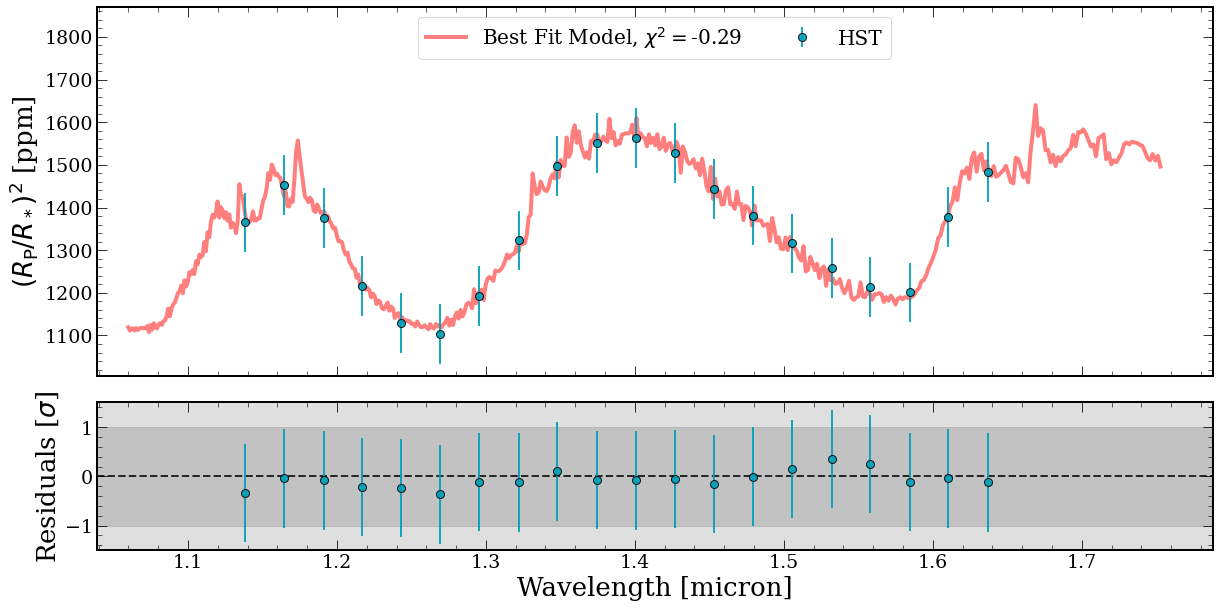

In [9]:
# Plotting the best fit spectrum
# This will generate a few warnings, but it's fine.
fig,ax,ax_r = retrieval.plot_spectra(samples_use,parameters_read)
plt.show()

Plotting PT profiles
Best fit likelihood = -0.29
Computing Best Fit Model, this may take a minute...
Loading best fit spectrum and contribution from file
(100, 504) (504,)


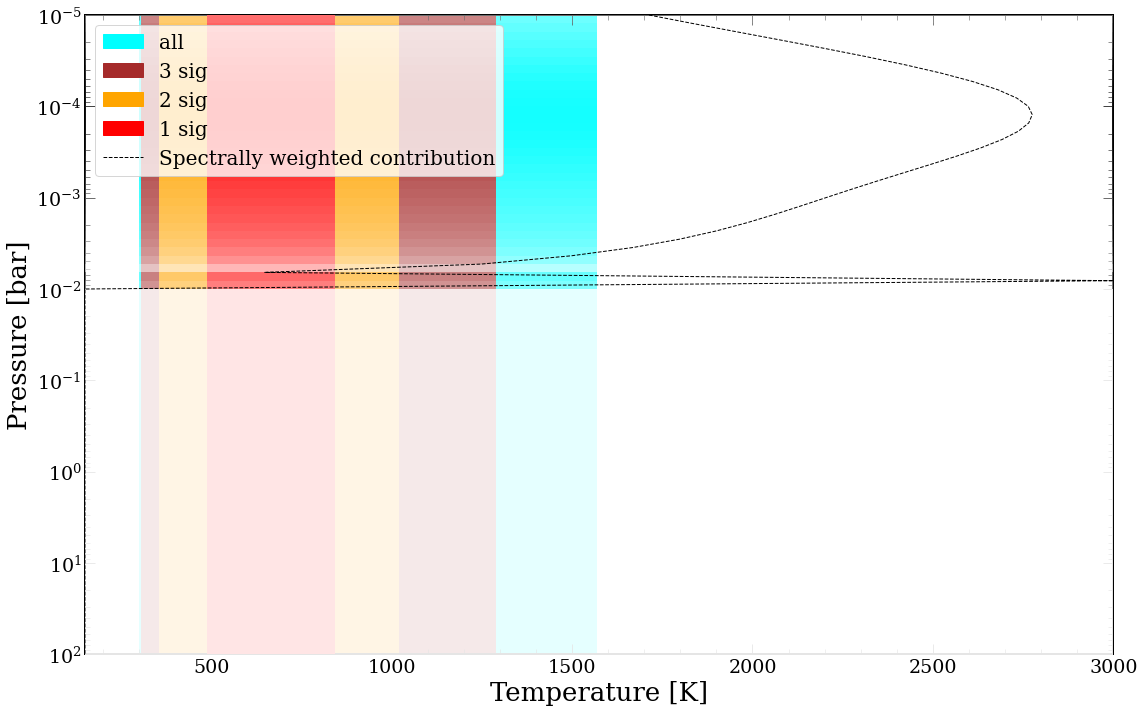

In [10]:
# Plotting the PT profile
fig,ax =retrieval.plot_PT(sample_dict,parameters_read, contribution = True)
plt.show()

(2179, 9)
Making corner plot
8


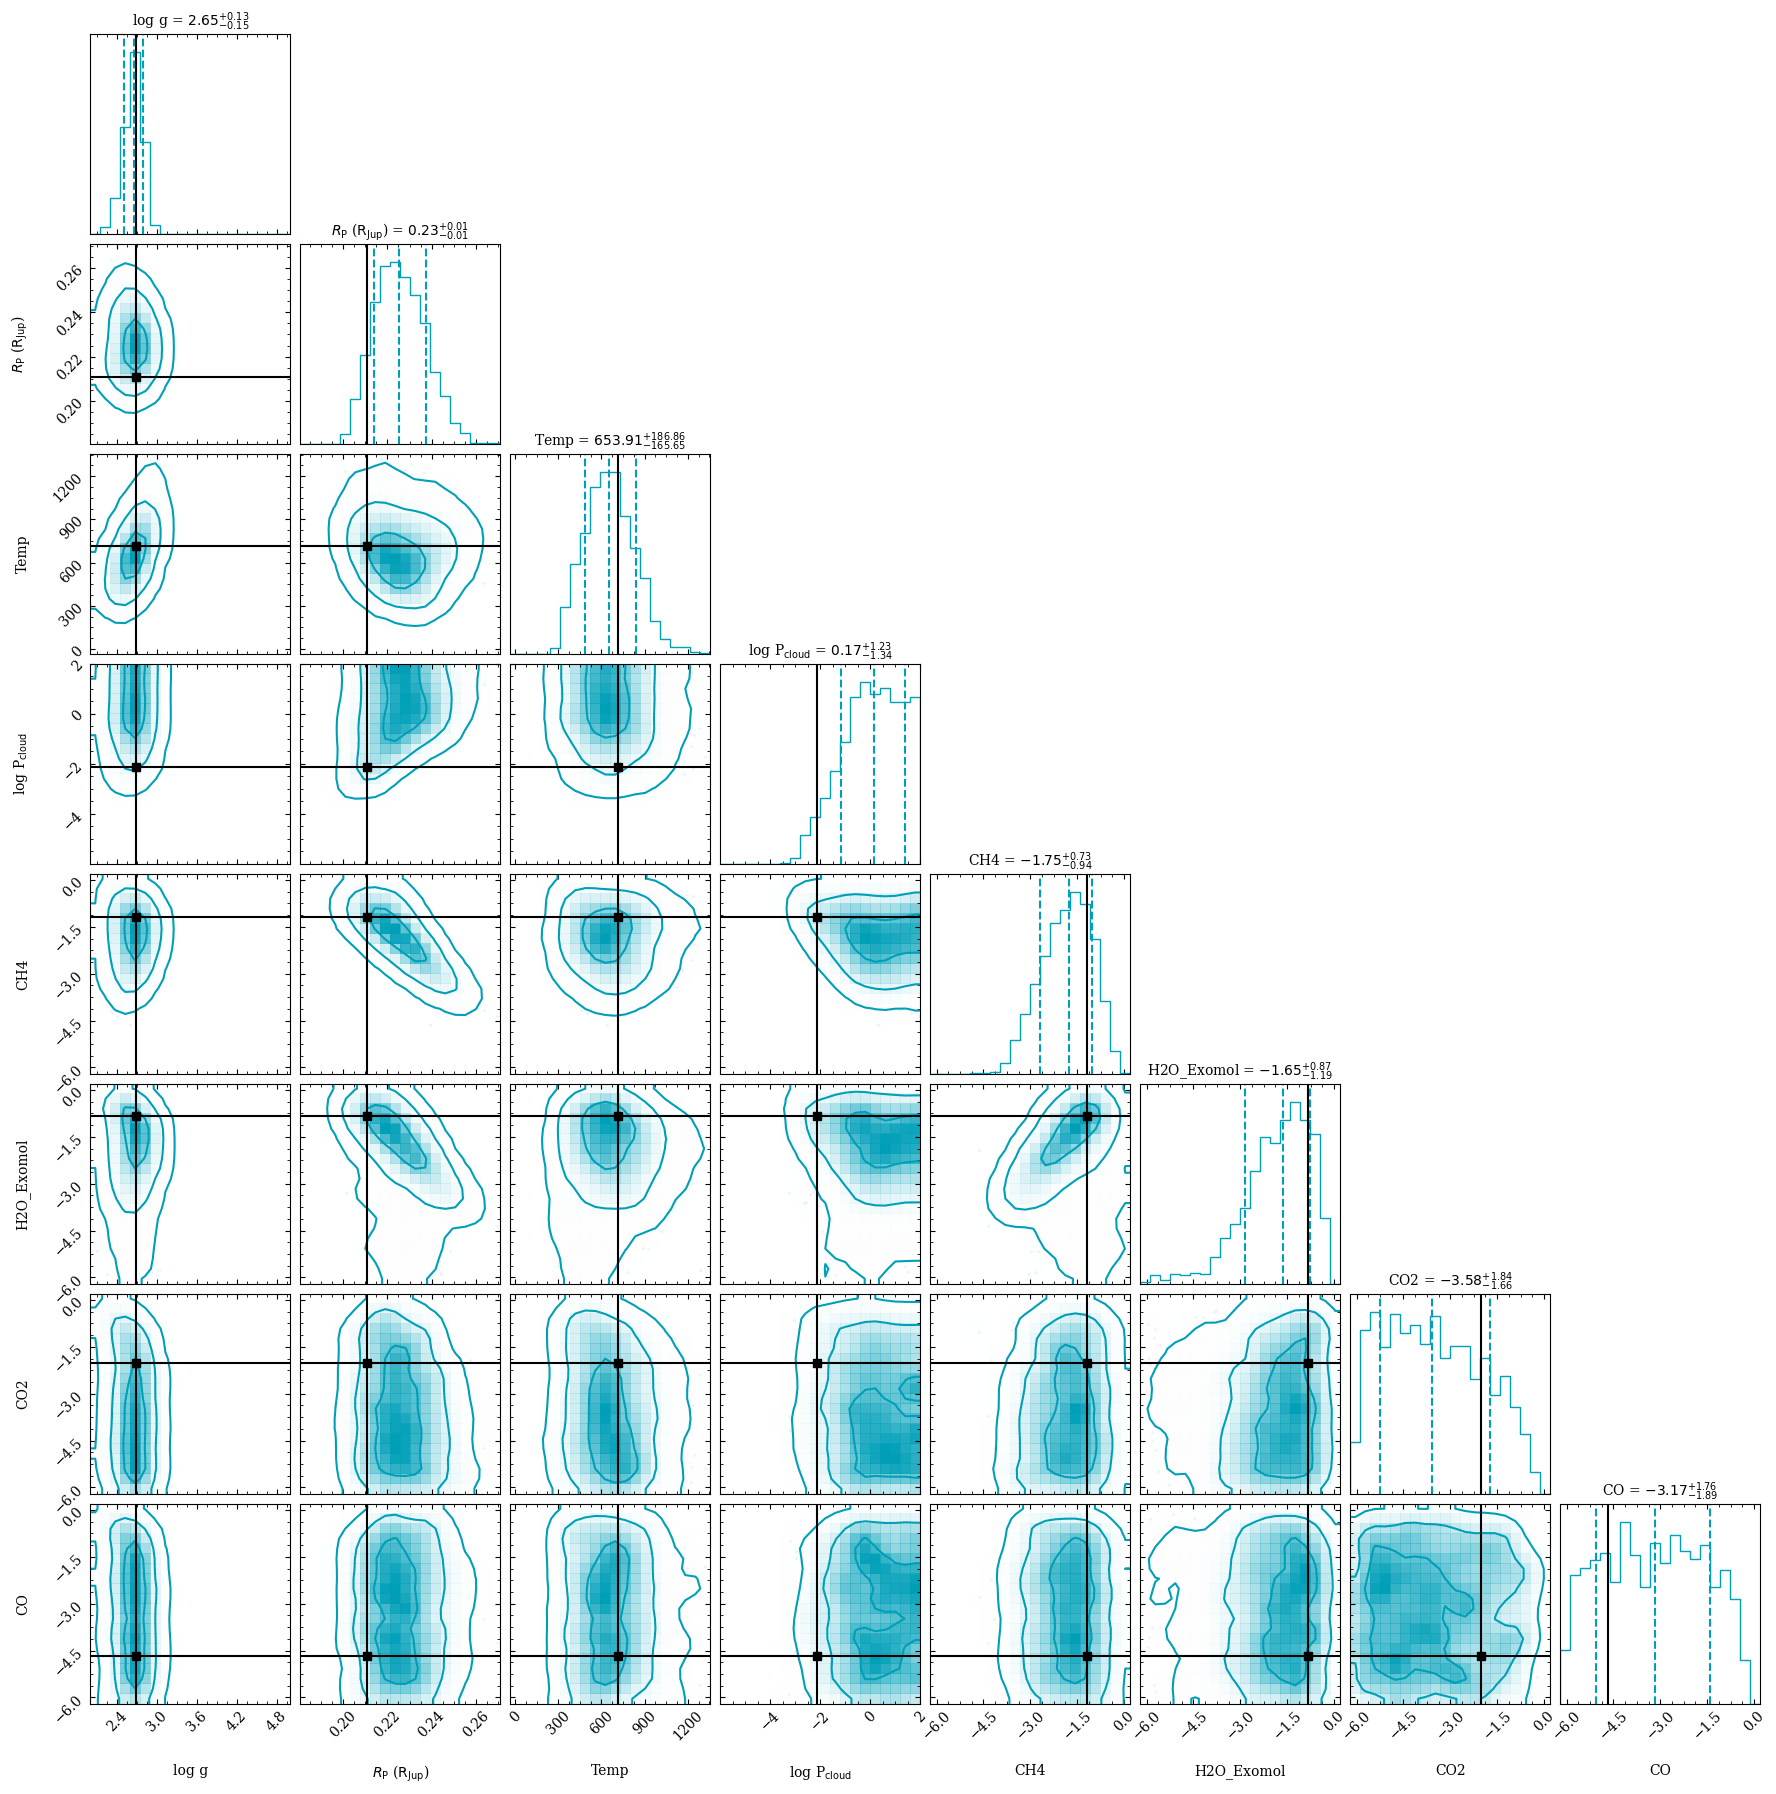

In [11]:
# Corner plot
# The corner plot produces 1,2 and 3 sigma contours for the 2D plots
print(sample_dict['hst_example_clear_spec'].shape)
retrieval.plot_corner(sample_dict,parameter_dict,parameters_read,title_kwargs = {"fontsize" : 10})
plt.show()

## Emission Spectrum Example

This retrieval is based on Mollière+20 for HR8799e, and shows a more realistic example of how to set up a retrieval.

For this example, the module poor_mans_noneq_chemistry is used to solve disequilibrium chemistry, and the cloud_cond module is used for cloud condensation. You can import other models from models.py, or write your own function, ensuring that it takes in the same set of inputs and outputs, which are documented in models, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/models/index.html).

This model uses a simple adaptive mesh refinement (AMR) algorithm to improve the pressure resolution around the location of the cloud bases.

In [5]:
##########################
# Define the pRT run setup
##########################

# retrieve.py expects this object to be called RunDefinition.
RunDefinition = RetrievalConfig(retrieval_name = "HR8799e_example", # Give a useful name for your retrieval 
                                run_mode = "retrieval", # 'retrieval' to run, or 'evaluate' to make plots
                                AMR = True,             # Adaptive mesh refinement, slower if True
                                scattering = True)      # Add scattering for emission spectra clouds

For this example we include the GRAVITY data as published in Mollière+20. To reproduce the published results, please also include the archival SPHERE and GPI data from [Zurlo et al. (2015)](https://www.aanda.org/articles/aa/full_html/2016/03/aa26835-15/aa26835-15.html) and [Greenbaum et al. (2016)](https://iopscience.iop.org/article/10.3847/1538-3881/aabcb8).

In [13]:
##################
# Read in Data
##################
RunDefinition.add_data('GRAVITY',
                       path_to_data + 'retrieval/examples/emission/HR8799e_Spectra.fits',
                       model_generating_function = emission_model_diseq)

## Photometric data

If we want to add photometry, we can do that as well! The photometry file should have the format:

`# Name, lower wavelength edge [um], upper wavelength edge [um], flux density [W/m2/micron], flux error [W/m2/micron]`

You are required to provide a model function for calculating the spectrum, as with spectral data, but also a photometric transformation function, which is used to convert the model spectrum into synthetic photometry. This would typically make use of the transmission function for a particular filter. We recommend the use of the `species` package (https://species.readthedocs.io/), in particular the `SyntheticPhotometry` module to provide these functions. If no function is provided, the RetrievalConfig will attempt to import `species` to use this module, using the `name` provided as the filter name.

If you are using transmission spectra, your photometric transformation function should model the difference between the clear and occulted stellar spectrum, returning the difference in (planet radius/stellar radius)^2.

In [14]:
RunDefinition.add_photometry(path_to_data + 'retrieval/examples/emission/hr8799e_photometry.txt',
                             emission_model_diseq,
                             model_resolution = 40)

Initiating species v0.2.1... [DONE]
A new version (0.3.6) is available!
Database: /Users/molliere/Documents/Project_Docs/petitRADTRANS/docs/content/notebooks/species_database.hdf5
Data folder: /Users/molliere/Documents/Project_Docs/petitRADTRANS/docs/content/notebooks/data
Working folder: /Users/molliere/Documents/Project_Docs/petitRADTRANS/docs/content/notebooks


## Parameters and Priors

Here we add all of the parameters used in the retrieval. 
Each parameter must be given a name, which matches the name used in the model function.
Parameters can be set to fixed or free. Fixed parameters must be given a value, while free parameters are given a function that transforms the unit hypercube generated by multinest into physical prior space. Various prior functions are stored in util, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/util/index.html).

In [15]:
#################################################
# Add parameters, and priors for free parameters.
#################################################

# This run uses the model of Molliere (2020) for HR8799e
# The lambda function provide uniform priors.

# Distance to the planet in cm
RunDefinition.add_parameter(name = 'D_pl', free = False, value = 41.2925*nc.pc)

# Log of the surface gravity in cgs units.
RunDefinition.add_parameter('log_g',True, 
                            transform_prior_cube_coordinate = \
                            lambda x : 2.+3.5*x)

# Planet radius in cm
RunDefinition.add_parameter('R_pl', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : ( 0.7+1.3*x)*nc.r_jup_mean)

# Temperature in Kelvin
RunDefinition.add_parameter('T_int', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : 300.+2000.*x,
                            value=0.0)

# Spline temperature structure parameters. T1 < T2 < T3
# As these priors depend on each other, they are implemented in the model function
RunDefinition.add_parameter('T3', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : x,
                            value=0.0)
RunDefinition.add_parameter('T2', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : x,
                            value=0.0)
RunDefinition.add_parameter('T1', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : x)
# Optical depth model
# power law index in tau = delta * press_cgs**alpha
RunDefinition.add_parameter('alpha', True, \
                            transform_prior_cube_coordinate = \
                            lambda x :1.0+x)
# proportionality factor in tau = delta * press_cgs**alpha
RunDefinition.add_parameter('log_delta', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : x) 
# Chemistry
# A 'free retrieval' would have each line species as a parameter
# Using a (dis)equilibrium model, we only supply bulk parameters.
# Carbon quench pressure
RunDefinition.add_parameter('log_pquench',True,\
                            transform_prior_cube_coordinate = \
                            lambda x : -6.0+9.0*x)
# Metallicity
RunDefinition.add_parameter('Fe/H',True,\
                            transform_prior_cube_coordinate = \
                            lambda x : -1.5+3.0*x)
# C/O ratio
RunDefinition.add_parameter('C/O',True,\
                            transform_prior_cube_coordinate = \
                            lambda x : 0.1+1.5*x)
# Clouds
# Based on an Ackermann-Marley (2001) cloud model
# Width of particle size distribution
RunDefinition.add_parameter('sigma_lnorm', True,
                            transform_prior_cube_coordinate = \
                            lambda x : 1.05 + 1.95*x) 
# Vertical mixing parameters
RunDefinition.add_parameter('log_kzz',True,\
                            transform_prior_cube_coordinate = \
                            lambda x : 5.0+8.*x) 
# Sedimentation parameter
RunDefinition.add_parameter('fsed',True,\
                            transform_prior_cube_coordinate = \
                            lambda x : 1.0 + 10.0*x)
# Data scaling
# If the luminosity of datasets does not agree, we can scale one or more of the datasets
# by a constant factor. 
# Scaling factor name must be the name of the Data class for
# the instrument, + "_scale_factor"                            
#RunDefinition.add_parameter('SPHERE_scale_factor',True,\
#                            transform_prior_cube_coordinate = \
#                            lambda x : 0.8 + 0.4 *x)

In [6]:
#######################################################
# Define species to be included as absorbers
#######################################################
RunDefinition.set_rayleigh_species(['H2', 'He'])
RunDefinition.set_continuum_opacities(['H2-H2', 'H2-He'])
RunDefinition.set_line_species(['CH4',
                                'H2O_HITEMP',
                                'CO2',
                                'HCN',
                                'CO_all_iso_HITEMP',
                                'FeH', 
                                'H2S',
                                'NH3',
                                'PH3',
                                'Na_allard',
                                'K_allard'],
                                eq = True)
RunDefinition.add_cloud_species('Fe(c)_cd',eq = True,abund_lim = (-3.5,1.0))
RunDefinition.add_cloud_species('MgSiO3(c)_cd',eq = True,abund_lim = (-3.5,1.0))

In [17]:
retrieval = Retrieval(RunDefinition,
                      output_dir = "",
                      sample_spec = False)

Setting up PRT Objects
  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of HCN...
 Done.
  Read line opacities of FeH...
 Done.
  Read line opacities of H2S...
 Done.
  Read line opacities of NH3...
 Done.
  Read line opacities of PH3...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.

Setting up AMR pressure grid.
  Read line opacities of CH4...
 Done.

Saving to /Users/molliere/Documents/programm_data/petitRADTRANS_public/input_data/opacities/lines/corr_k/
Resolution:  40
Rebinning species CH4...
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of H2O_HITEMP_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of PH3_R_40...


In [18]:
# Before we run the retrieval, let's set up plotting.

##################################################################
# Define what to put into corner plot if run_mode == 'evaluate'
##################################################################
RunDefinition.parameters['R_pl'].plot_in_corner = True
RunDefinition.parameters['R_pl'].corner_label = r'$R_{\rm P}$ ($\rm R_{Jup}$)'
RunDefinition.parameters['R_pl'].corner_transform = lambda x : x/nc.r_jup_mean
RunDefinition.parameters['log_g'].plot_in_corner = True
RunDefinition.parameters['log_g'].corner_ranges = [2., 5.]
RunDefinition.parameters['log_g'].corner_label = "log g"
RunDefinition.parameters['fsed'].plot_in_corner = True
RunDefinition.parameters['log_kzz'].plot_in_corner = True
RunDefinition.parameters['log_kzz'].corner_label = "log Kzz"
RunDefinition.parameters['C/O'].plot_in_corner = True
RunDefinition.parameters['Fe/H'].plot_in_corner = True
RunDefinition.parameters['log_pquench'].plot_in_corner = True
RunDefinition.parameters['log_pquench'].corner_label = "log pquench"

for spec in RunDefinition.cloud_species:
    cname = spec.split('_')[0]
    RunDefinition.parameters['log_X_cb_'+cname].plot_in_corner = True
    RunDefinition.parameters['log_X_cb_'+cname].corner_label = cname

##################################################################
# Define axis properties of spectral plot if run_mode == 'evaluate'
##################################################################
RunDefinition.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'

RunDefinition.plot_kwargs["spec_ylabel"] = "Flux [W/m2/micron]"
RunDefinition.plot_kwargs["y_axis_scaling"] = 1.0
RunDefinition.plot_kwargs["xscale"] = 'log'
RunDefinition.plot_kwargs["yscale"] = 'linear'
RunDefinition.plot_kwargs["resolution"] = 100.# Maximum resolution, will rebin the data
RunDefinition.plot_kwargs["nsample"] = 100 # If we want a plot with many sampled spectra

##################################################################
# Define from which observation object to take P-T
# in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
##################################################################
RunDefinition.plot_kwargs["take_PTs_from"] = 'GRAVITY'
RunDefinition.plot_kwargs["temp_limits"] = [150, 3000]
RunDefinition.plot_kwargs["press_limits"] = [1e2, 1e-5]

In [ ]:
retrieval = Retrieval(RunDefinition,
                      output_dir = "",
                      sample_spec = False)
retrieval.run(n_live_points = 2000,
	      sampling_efficiency=0.05,
          const_efficiency_mode=True,
	      resume = True)

In [ ]:
retrieval.plot_all(contribution = True)

**Contact**

If you need any additional help, don't hesitate to contact [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals).